# 4.1 Kernel PCA: Toy Data

Group name: DataFun

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

### (a) Create toy dataset

(90, 2)


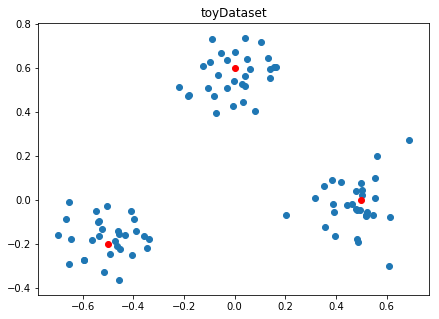

In [51]:
xMean = np.asarray([[-0.5, -0.2],[0, 0.6],[0.5, 0]])
sd = 0.1
toyDataset = np.empty([0,2])
for mean in xMean:
    toyDatasetPart = np.random.normal(mean, sd, [30,2])
    toyDataset = np.concatenate((toyDataset, toyDatasetPart), axis=0)

print(toyDataset.shape)

# Plotting the results.
plt.figure(figsize=(7,5))
plt.scatter(toyDataset[:,0], toyDataset[:,1])
plt.scatter(xMean[:,0], xMean[:,1], color="r")
plt.title("toyDataset")
plt.show()

### (b) Apply Kernel PCA using RBF Kernel

In [60]:
def k(x_a, x_b, sig):
    norm = np.linalg.norm(x_a - x_b)
    return np.exp(- norm**2 / (2*sig**2))
    
def createKernelMatrix(x, sig):
    p = x.shape[0] 
    KUnnormalized = np.empty([p,p])
    for i in range(p):
        for j in range(p):
            KUnnormalized[i,j] = k(x[i], x[j], sig)
    return KUnnormalized

def centerKernelMatrix(KUC):
    p = KUC.shape[0] 
    K = np.empty([p,p])
    rowAverages = np.average(KUC, axis=0)
    lineAverages = np.average(KUC, axis=1)
    matrixAverge = np.average(KUC)
    for i in range(p):
        for j in range(p):
            K[i,j] = KUC[i,j] - rowAverages[i] - lineAverages[j] + matrixAverge
    return K


sig = 1
KernelMatrixUnnormalized = createKernelMatrix(toyDataset, sig)
print("unnormalized KM shape: ", KernelMatrixUnnormalized.shape)
centerdKernelMatrixUnnormalized = centerKernelMatrix(KernelMatrixUnnormalized)
print("centered KM shape:", centerdKernelMatrixUnnormalized.shape)

def getOrderedEig(matrix):
    eigenvals, eigenvecs = np.linalg.eig(matrix)
    orderedInd = np.argsort(eigenvals)[::-1]
    orderedEigenvals = eigenvals[orderedInd]
    orderedEigenvecs = eigenvecs[orderedInd]
    return (orderedEigenvals, orderedEigenvecs)

orderedEigenvalues, orderedEigenvectors = getOrderedEig(centerdKernelMatrixUnnormalized)
print("orderedEigenvectors.shape:", orderedEigenvectors.shape)

def normalizeEV(orderedEigenvals, orderedEigenvecs):
    p = orderedEigenvals.shape[0]
    normEV = np.empty([p,p])
    for i in range(p):
        normEV = orderedEigenvecs / np.sqrt(p*orderedEigenvals[i])
    return normEV

normalizedEigenvectors = normalizeEV(orderedEigenvalues, orderedEigenvectors)
print("normalizeEigenvectors.shape:", normalizedEigenvectors.shape)



unnormalized KM shape:  (90, 90)
centered KM shape: (90, 90)
orderedEigenvectors.shape: (90, 90)
normalizeEigenvectors.shape: (90, 90)


### (c) Visualize first 8 PC

### (d) Discuss suitable applications for KPCA